## Tracking the performance of the Florida Retirement System pension fund

### 1.0 Introduction

This notebook uses **[SAS](https://www.sas.com/en_us/software/university-edition.html)** to visualize the performance of the [Florida Retirement System](https://www.myfrs.com/) pension fund, one of the [largest](https://en.wikipedia.org/wiki/State_Board_of_Administration_of_Florida) in the United States. The data is from the [Center for Retirement Research at Boston College](https://publicplansdata.org/about/our-research/), which tracks 180 pension funds across the United States. The performance of the fund is compared to those of other large funds.

Reading the data:

In [486]:
/*Reading in the dataset*/
proc import datafile="pension_plans/pension_plans.csv"
    out=pension_plans
    dbms=csv
    replace;
    getnames=yes;
    /*guessingrows=max makes it go a lot slower but it's necessary because
      if the first rows of a numeric column are blanks, SAS labels the column
      as a text (character) column*/
    guessingrows=max;
run;


/*I want to print the dataset dimensions.
  The CONTENTS statement prints a *screenful* of information.
  I just need the number of rows and columns. Using the option
  "short" creates a dataset pension_plans_columns where each 
  observation is a variable from the original data set.*/
  
proc contents 
    data=pension_plans out=pension_plans_columns short noprint; 
run;

/*Then we create two dummy tables, one from the original dataset
  and one from the columns dataset, and merge them*/
pro sql;
    title j=l "Reading the data" ;
    /*Creating dummy tables NumRowsTable and NumColumnsTable*/
    create table NumRowsTable as 
        select count(*) as Number_of_rows label = "Number of rows" from pension_plans;
    create table NumColumnsTable as
        select count(*) as Number_of_columns label = "Number of columns" from pension_plans_columns;
    
    /*Adding a Dataset column to both dummy tables so we have something to merge on*/
    alter table NumRowsTable
      add Dataset char(30);
    update NumRowsTable
      set Dataset = "pension_plans dataset";
    alter table NumColumnsTable
      add Dataset char(30);
    update NumColumnsTable
      set Dataset = "pension_plans dataset";
run;

/*Merging the two tables*/
data NumRowsAndColumns;
    merge work.NumRowsTable work.NumColumnsTable;
    by Dataset;
run;

/*Finally*/
proc sql;
    select Dataset, Number_of_Rows, Number_of_columns from NumRowsAndColumns;
run;

Dataset,Number of rows,Number of columns
pension_plans dataset,3222,267


### 2.0 FRS Asset Allocations and Performance by Asset Class

SAS comes with its own version of [SQL](https://en.wikipedia.org/wiki/SQL), which we can use to get the asset allocations of FRS. The CRR provides detailed [documentation](https://publicplansdata.org/public-plans-database/documentation/) of the dataset, so we know which columns to query.

In [340]:
proc sql;
    title j=l "Investment allocations of FRS";
    create table pension_plans_frs_alloc as
        select PlanName, fy as Year, 
            EQTotal_Actl format=percent8.2 as Equities, 
            FITotal_Actl format=percent8.2 as Fixed_Income, 
            RETotal_Actl format=percent8.2 as Real_Estate, 
            PETotal_Actl format=percent8.2 as Private_Equity, 
            HFTotal_Actl format=percent8.2 as Hedge_Funds,
            CashTotal_Actl format=percent8.2 as Cash
        from work.pension_plans
        where PlanName = "Florida RS";
    
    select * from work.pension_plans_frs_alloc; /*show new table*/
quit;

PlanName,Year,Equities,Fixed_Income,Real_Estate,Private_Equity,Hedge_Funds,Cash
Florida RS,2001,66.06%,25.28%,4.11%,3.58%,.,0.97%
Florida RS,2002,63.67%,26.32%,4.25%,3.33%,.,2.43%
Florida RS,2003,67.20%,23.00%,4.60%,3.40%,.,1.40%
Florida RS,2004,70.00%,20.20%,5.70%,3.40%,.,0.50%
Florida RS,2005,69.93%,21.68%,4.90%,3.20%,.,0.30%
Florida RS,2006,69.90%,21.30%,4.90%,3.10%,.,0.80%
Florida RS,2007,59.30%,24.20%,6.00%,3.20%,4.40%,2.90%
Florida RS,2008,54.15%,29.77%,7.69%,3.40%,4.10%,0.90%
Florida RS,2009,55.74%,28.57%,7.79%,3.60%,3.40%,0.90%
Florida RS,2010,54.39%,30.54%,6.49%,4.09%,4.09%,0.40%


We can use `sgplot` to plot the asset allocations over time.


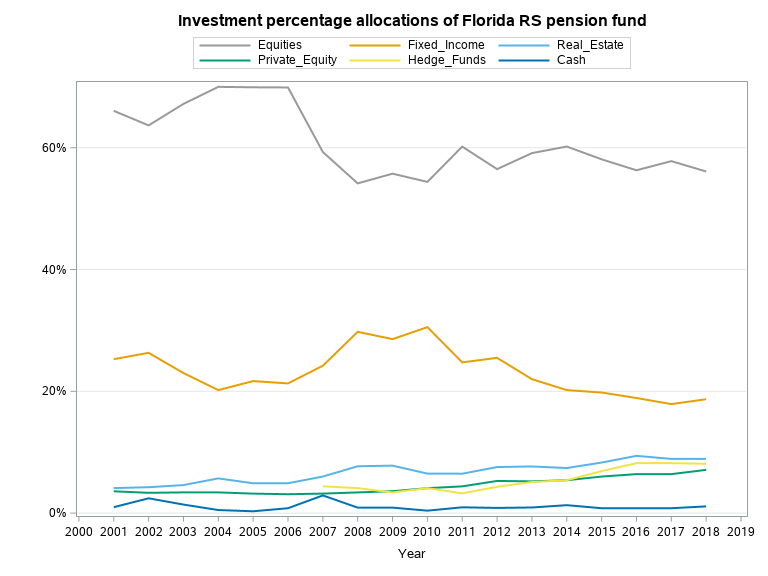

In [503]:
proc sgplot data=work.pension_plans_frs_alloc;
    series x=Year y=Equities / lineattrs=(color=CX999999 thickness=2);     
    series x=Year y=Fixed_Income / lineattrs=(color=CXE69F00 thickness=2);
    series x=Year y=Real_Estate / lineattrs=(color=CX56B4E9 thickness=2);
    series x=Year y=Private_Equity / lineattrs=(color=CX009E73 thickness=2);
    series x=Year y=Hedge_Funds / lineattrs=(color=CXF0E442 thickness=2);
    series x=Year y=Cash / lineattrs=(color=CX0072B2 thickness=2);
    
    yaxis grid label=" " ;
    xaxis values=(2000 to 2019 by 1);
    title "Investment percentage allocations of Florida RS pension fund" ;
    ods graphics / noborder;
    keylegend / position=top;
    ods graphics on / width=8in;
run;



FRS used to allocate about 90% of its funds to equities and fixed income investments, but has reduced its allocations to those two asset classes to about 75%. FRS has roughly doubled its allocations to real estate and private equity, and has diversified into hedge funds as well.

We can run nearly identical code to tabulate and plot the returns for each asset class, as well as the total yearly returns.

In [205]:
proc sql;
    create table pension_plans_frs_alloc_returns as
        select PlanName, fy as Year, 
            EQTotal_Rtrn format=percent8.2 as Equities, 
            FITotal_Rtrn format=percent8.2 as Fixed_Income, 
            RETotal_Rtrn format=percent8.2 as Real_Estate, 
            PETotal_Rtrn format=percent8.2 as Private_Equity, 
            HFTotal_Rtrn format=percent8.2 as Hedge_Funds,
            CashTotal_Rtrn format=percent8.2 as Cash,
            InvestmentReturn_1yr format=percent8.2 as Total
        from work.pension_plans
        where PlanName = "Florida RS";
    
    select * from work.pension_plans_frs_alloc_returns; /*show new table*/
    title j=l "Investment returns by asset class of Florida RS pension fund" ;
quit;

PlanName,Year,Equities,Fixed_Income,Real_Estate,Private_Equity,Hedge_Funds,Cash,Total
Florida RS,2001,(15.33%),10.90%,11.60%,13.40%,.,6.10%,( 7.60%)
Florida RS,2002,(14.70%),8.20%,10.80%,9.20%,.,2.60%,( 8.07%)
Florida RS,2003,( 0.39%),11.40%,7.20%,6.90%,.,5.10%,2.85%
Florida RS,2004,23.08%,1.36%,12.75%,.,.,1.06%,16.65%
Florida RS,2005,10.38%,7.03%,21.99%,5.94%,.,2.31%,10.18%
Florida RS,2006,13.30%,0.02%,23.48%,.,.,4.31%,10.56%
Florida RS,2007,22.43%,6.53%,16.11%,12.90%,18.31%,5.43%,18.07%
Florida RS,2008,(10.55%),4.80%,8.69%,7.50%,( 8.86%),0.86%,( 4.42%)
Florida RS,2009,(27.50%),2.08%,(21.16%),(25.82%),(34.58%),5.37%,(19.03%)
Florida RS,2010,15.30%,15.21%,10.15%,21.44%,28.88%,1.96%,14.03%



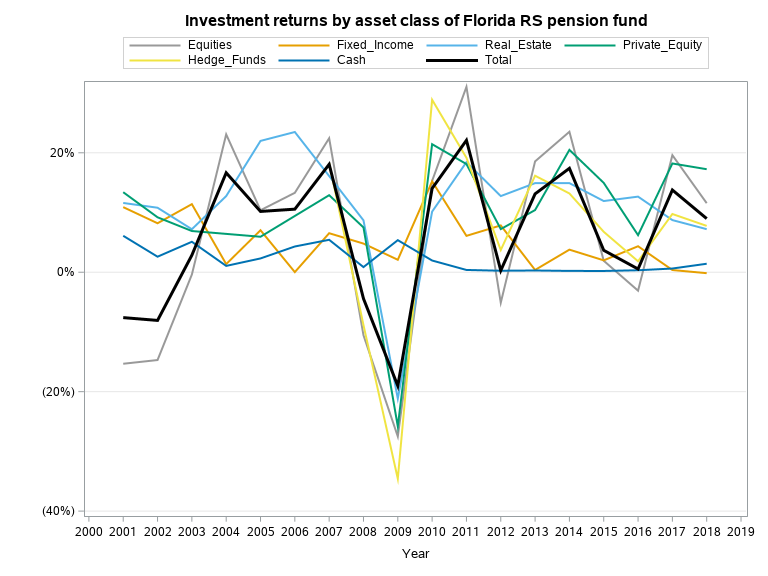

In [501]:
proc sgplot data=work.pension_plans_frs_alloc_returns;
    series x=Year y=Equities / lineattrs=(color=CX999999 thickness=2);     
    series x=Year y=Fixed_Income / lineattrs=(color=CXE69F00 thickness=2);
    series x=Year y=Real_Estate / lineattrs=(color=CX56B4E9 thickness=2);
    series x=Year y=Private_Equity / lineattrs=(color=CX009E73 thickness=2);
    series x=Year y=Hedge_Funds / lineattrs=(color=CXF0E442 thickness=2);
    series x=Year y=Cash / lineattrs=(color=CX0072B2 thickness=2);
    series x=Year y=Total / lineattrs=(color=CX000000 thickness=3);
    
    yaxis grid label=" " ;
    xaxis values=(2000 to 2019 by 1);
    title "Investment returns by asset class of Florida RS pension fund" ;
    ods graphics / noborder;
    keylegend / position=top;
    ods graphics on / width=8in;
run;



### 3.0 Comparing FRS to other large funds

I wanted to see how the performance of FRS compared to those of other large funds. Besides return on investment, a fund is graded on the [funded ratio](https://www.actuary.org/sites/default/files/files/80_Percent_Funding_IB_071912.pdf): its assets divided by its liabilities. Ideally, it should be at least 1. The code below tabulates the return on investment and the funded ratio of the 25 largest funds by assets in the United States in 2016.

In [356]:
/*Displaying the top 25 funds by assets
  You have to do it in two steps. First you CREATE the table you want, 
  ordered by assets...*/
  
proc sql;
  create table top_funds_by_assets as
    select PlanName, StateName, fy as Year, ActAssets_GASB format=dollar14.0 as PlanAssets,
           InvestmentReturn_1yr format=percent8.2 as Return_1yr,
           ActFundedRatio_GASB format=percent8.2 as FundedRatio
    from work.pension_plans
    where fy = 2016  
    order by PlanAssets desc;
    title j=l "2016 returns and funded ratios of the 25 largest pension funds by assets" ;    
run;

/*...and then you  tell SAS to put the first 25 rows
  from that table and put them in a new table*/
  
proc sql inobs=25;
    create table top25_funds_by_assets as
      select * from top_funds_by_assets;    
run;

/*Display your table*/
proc sql;
    select * from top25_funds_by_assets;    
run;

PlanName,StateName,Year,PlanAssets,Return_1yr,FundedRatio
California PERF,California,2016,"$298,126,000",0.60%,68.30%
California Teachers,California,2016,"$169,976,000",1.35%,63.70%
NY State & Local ERS,New York,2016,"$162,119,000",0.19%,94.12%
Florida RS,Florida,2016,"$145,451,612",0.54%,85.40%
Texas Teachers,Texas,2016,"$138,786,000",1.30%,79.70%
New York State Teachers,New York,2016,"$107,039,200",2.30%,97.90%
Wisconsin RS,Wisconsin,2016,"$95,396,200",8.60%,100.0%
Ohio PERS,Ohio,2016,"$80,267,000",8.31%,80.14%
Ohio Teachers,Ohio,2016,"$70,114,637",0.92%,69.60%
Georgia Teachers,Georgia,2016,"$68,161,710",1.40%,74.30%


We see that only the Wisconsin pension fund met the target.

We can also have SAS create a column where each fund's position in a ranking is shown. For example, if we wanted to show the ranking of funds by funded ratio in the table above:

In [435]:
proc rank data=work.top25_funds_by_assets ties=low out=work.top25_funds_by_assets_ranked_1 descending;
    var FundedRatio; /*variable by which you want to rank*/
    ranks FundedRatioRank; /*name of column with the rankings*/
run;

/*Only showing the first 10 rows to save space*/
proc print data=work.top25_funds_by_assets_ranked_1 (obs=10);
title "  ";
run;

Obs,PlanName,StateName,Year,PlanAssets,Return_1yr,FundedRatio,FundedRatioRank
1,California PERF,California,2016,"$298,126,000",0.60%,68.30%,20
2,California Teachers,California,2016,"$169,976,000",1.35%,63.70%,21
3,NY State & Local ERS,New York,2016,"$162,119,000",0.19%,94.12%,4
4,Florida RS,Florida,2016,"$145,451,612",0.54%,85.40%,8
5,Texas Teachers,Texas,2016,"$138,786,000",1.30%,79.70%,12
6,New York State Teachers,New York,2016,"$107,039,200",2.30%,97.90%,2
7,Wisconsin RS,Wisconsin,2016,"$95,396,200",8.60%,100.0%,1
8,Ohio PERS,Ohio,2016,"$80,267,000",8.31%,80.14%,11
9,Ohio Teachers,Ohio,2016,"$70,114,637",0.92%,69.60%,19
10,Georgia Teachers,Georgia,2016,"$68,161,710",1.40%,74.30%,17


I have only shown the first 10 rows. We can see FRS ranked number 8 among the largest funds in the U.S. in 2016.

Doing it for a single year, by itself, is not that useful. We could just have ordered the 2016 Top-25 funds table by funded ratio and seen where FRS ranked that year. However, I wanted to see where FRS ranked ***each year*** among the largest 25 funds, on both funded ratio and return on investment. We certainly wouldn't want to scan 15 or so tables. SAS lets us loop over values using `DO`, and create functions using `macro`, so we can avail ourselves of both of those features.

In [437]:
%macro sqlloop(start,end); 
    
    /*Creating the top-25-funds-by-assets tables, from start=2001 to end=2016
      The procedure is exactly the same as before, except now it's embedded
      in a loop.*/
   %DO year=&start. %TO &end.;
     PROC SQL;  
       CREATE TABLE temp_table as 
            select PlanName, StateName, fy as Year, ActAssets_GASB format=dollar14.0 as PlanAssets,
            InvestmentReturn_1yr format=percent8.2 as Return_1yr,
            ActFundedRatio_GASB format=percent8.2 as FundedRatio
            from work.pension_plans
            where fy = &year.
            order by PlanAssets desc;
     RUN;
     
     PROC SQL inobs=25;
       CREATE TABLE FRS_Perf_&year. as
         select * from temp_table
     RUN;
   %END;
   
   /*Creating a table for each year where the top-25 funds are ranked by returns.
     Also almost identical to what we had before, but now embedded in a loop*/
   %DO year=&start. %TO &end.;
     proc rank data=work.FRS_Perf_&year. ties=low out=FRS_Perf_ranked_returns_&year. descending;
       var Return_1yr;
       ranks ReturnsRank;
     run;
     
   %END;
   
   /*Creating a table for each year where the top-25 funds are ranked by funded ratio.*/
   %DO year=&start. %TO &end.;
     proc rank data=work.FRS_Perf_&year. ties=low out=work.FRS_Perf_ranked_fundratio_&year. descending;
       var FundedRatio;
       ranks FundedRatioRank;
     run;
     
   %END;
   
   /*Now we will create a table that shows FRS' yearly ranking by returns
     First we create the table and put in the first row, by querying the
     2001 table with the ranked returns*/
   proc sql;
     create table Florida_RS_Perf_Rank_Returns as
       select * from work.FRS_Perf_ranked_returns_2001
       where PlanName='Florida RS' and Year=2001;  
   quit;
   
   /*Then we loop over the 2002-2016 tables with the ranked returns, 
     querying them and inserting the relevant rows into the yearly 
     rankings table*/
   proc sql;
     %DO year=2002 %TO &end.;
       insert into Florida_RS_Perf_Rank_Returns
         /*values ('Florida RS', 'Florida', 2001, '$95,517,948', '( 7.60%)', 12, 19);*/
         select * from work.FRS_Perf_ranked_returns_&year.
         where PlanName='Florida RS' and Year=&year.;
     %END;
   quit;
   
   /*Now we repeat what we just did to create a table that shows FRS' 
     yearly ranking by funded ratio*/
   proc sql;
     create table Florida_RS_Perf_Rank_FundRatio as
       select * from work.FRS_Perf_ranked_fundratio_2001
       where PlanName='Florida RS' and Year=2001;  
   quit;
   
   proc sql;
     %DO year=2002 %TO &end.;
       insert into Florida_RS_Perf_Rank_FundRatio
         /*values ('Florida RS', 'Florida', 2001, '$95,517,948', '( 7.60%)', 12, 19);*/
         select * from work.FRS_Perf_ranked_fundratio_&year.
         where PlanName='Florida RS' and Year=&year.;
     %END;
   quit;

%mend; 

/*Call the macro*/
%sqlloop(start=2001, end=2016)

/*Merge the two tables*/

data Florida_RS_Perf_Rank_merged;
    merge work.Florida_RS_Perf_Rank_Returns work.Florida_RS_Perf_Rank_FundRatio;
    by Year;
run;

/*Display the table
  The rank proc *labels* the columns, which makes it very confusing
  when you want to plot the table later, so I created a second merged
  table and changed the labels. :| */

proc sql;
    create table Florida_RS_Perf_Rank_merged2 as
        select PlanName, Year, PlanAssets, Return_1yr, FundedRatio, 
               ReturnsRank label="ReturnsRank", FundedRatioRank label="FundedRatioRank"
        from work.Florida_RS_Perf_Rank_merged;
    select * from Florida_RS_Perf_Rank_merged2;
    title j=l "FRS ranking in returns and funded ratio among 25 largest funds in the U.S., 2001-2016";
run;

PlanName,Year,PlanAssets,Return_1yr,FundedRatio,ReturnsRank,FundedRatioRank
Florida RS,2001,"$95,517,948",( 7.60%),117.9%,15,4
Florida RS,2002,"$99,405,677",( 8.07%),115.0%,13,3
Florida RS,2003,"$101,906,723",2.85%,114.2%,18,2
Florida RS,2004,"$106,707,426",16.65%,112.1%,7,2
Florida RS,2005,"$111,539,878",10.18%,107.3%,14,3
Florida RS,2006,"$117,159,615",10.56%,105.6%,15,2
Florida RS,2007,"$125,584,704",18.07%,105.7%,12,4
Florida RS,2008,"$130,720,547",( 4.42%),105.4%,12,4
Florida RS,2009,"$118,764,692",(19.03%),87.88%,14,8
Florida RS,2010,"$120,929,666",14.03%,87.99%,8,6


We can see that FRS consistently ranks in the top third of funds in funded ratio and slightly below the middle in returns.

Plotting the rankings:


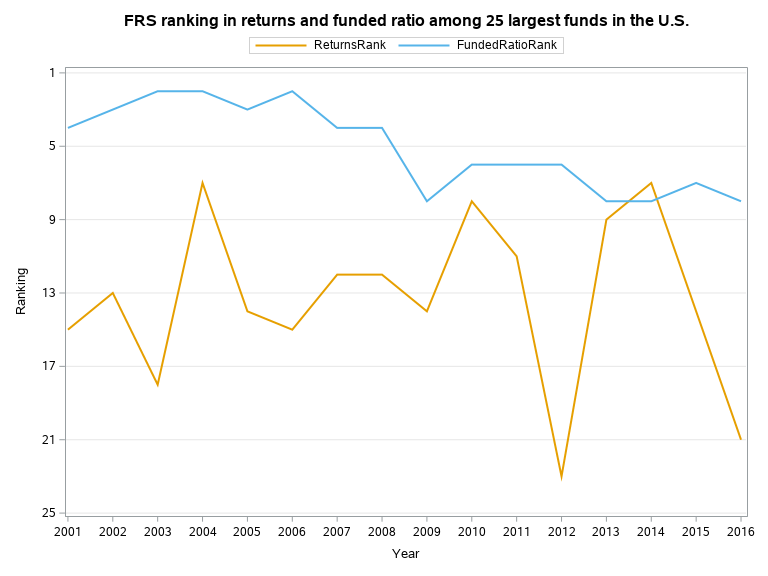

In [505]:
proc sgplot data=work.Florida_RS_Perf_Rank_merged2;
    series x=Year y=ReturnsRank / lineattrs=(color=CXE69F00 thickness=2);
    series x=Year y=FundedRatioRank / lineattrs=(color=CX56B4E9 thickness=2);
    xaxis values=(2001 to 2016 by 1);
    yaxis reverse grid label=" " values =(1 to 25 by 4) labe="Ranking";
    title "FRS ranking in returns and funded ratio among 25 largest funds in the U.S.";
    keylegend / position=top;
    ods graphics on / width=8in;
run;

### References
1. [PUBLIC PLANS DATA](https://publicplansdata.org/public-plans-database/)
2. [How to get all the columns from CSV file](https://communities.sas.com/t5/SAS-Programming/How-to-get-all-the-columns-from-CSV-file/td-p/357372)
3. [Rounding up, rounding down](http://proc-x.com/2011/10/rounding-up-rounding-down/)
4. [SGPLOT - How to remove the border on a graph?](https://communities.sas.com/t5/Graphics-Programming/SGPLOT-How-to-remove-the-border-on-a-graph/td-p/337159)
5. [Basic SAS Procedures - PROC CONTENTS](https://www.cpc.unc.edu/research/tools/data_analysis/sastopics/contents)
6. [how to plot multiple data on same graph](https://communities.sas.com/t5/Graphics-Programming/how-to-plot-multiple-data-on-same-graph/td-p/392588)
7. [Introduction to merging in SAS](https://www.cpc.unc.edu/research/tools/data_analysis/sastopics/merge)
8. [The 80% Pension Funding Standard Myth](https://www.actuary.org/sites/default/files/files/80_Percent_Funding_IB_071912.pdf)
9. [How to left justify title](https://communities.sas.com/t5/ODS-and-Base-Reporting/How-to-left-justify-title/td-p/51080)
10. [Limiting results in PROC SQL](https://stackoverflow.com/questions/11746815/limiting-results-in-proc-sql)
11. [Using PROC RANK and PROC UNIVARIATE to Rank or Decile Variables](https://www.lexjansen.com/nesug/nesug09/ap/AP01.pdf)
12. [DO loop in PROC SQL](https://communities.sas.com/t5/SAS-Programming/DO-loop-in-PROC-SQL/td-p/13486)
13. [5 tips for customizing legends in PROC SGPLOT in SAS](https://blogs.sas.com/content/iml/2018/12/03/tips-customize-legends-proc-sgplot.html)